[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Lowe_et_al_2019/fig_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_1.ipynb)

#### based on Fig. 1 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from matplotlib import pyplot
import numpy as np
from PySDM import Formulae
from PySDM.initialisation import spectra
from PySDM.physics import si
from open_atmos_jupyter_utils import show_plot

from PySDM_examples.Lowe_et_al_2019.aerosol_code import AerosolMarine, AerosolBoreal, AerosolNascent
from PySDM_examples.Lowe_et_al_2019.constants_def import LOWE_CONSTS

In [3]:
FORMULAE = Formulae(constants=LOWE_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
cases = {
    'Marine (MA)': AerosolMarine(water_molar_volume=WATER_MOLAR_VOLUME),
    'Boreal (HYY)': AerosolBoreal(water_molar_volume=WATER_MOLAR_VOLUME),
    'NUM event (NE)': AerosolNascent(water_molar_volume=WATER_MOLAR_VOLUME)
}

formulae_bulk = Formulae(
    surface_tension='Constant',
    constants=LOWE_CONSTS, 
)
formulae_surf = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants=LOWE_CONSTS,
)

r_wet = np.logspace(np.log(150 * si.nm), np.log(3000 * si.nm), base=np.e, num=100)
r_dry = 50 * si.nm
v_wet = formulae_surf.trivia.volume(r_wet)
v_dry = formulae_surf.trivia.volume(r_dry)
T = 300 * si.K
r_wet_ticks_nm = (300, 500, 700, 1000, 3000)

### Fig. 1 a

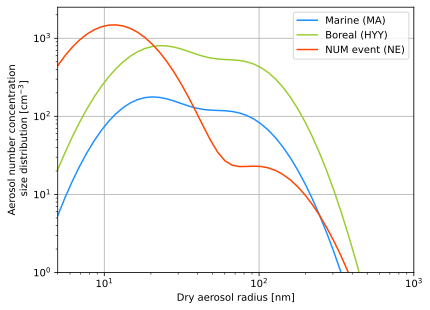

In [4]:
x = np.logspace(np.log(5 * si.nm), np.log(1000 * si.nm), base=np.e)
for k, v in cases.items():
    spec = spectra.Sum(
        tuple(v.modes[i]['spectrum'] for i in range(len(v.modes)))
    )
    pyplot.loglog(x / si.nm, spec.size_distribution(x)*x / si.cm**-3, label=k, color=v.color)
pyplot.ylim(1, 2500)
pyplot.xlim(5, 1000)
pyplot.legend()
pyplot.grid()
pyplot.xlabel('Dry aerosol radius [nm]')
pyplot.ylabel('Aerosol number concentration\n size distribution [cm$^{-3}$]')
show_plot("fig_1a.pdf")

### Fig. 1 c

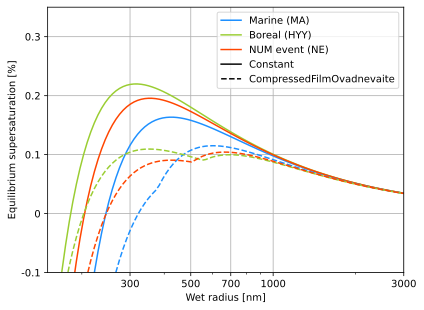

In [5]:
rd3 = r_dry**3
        
for formulae in (formulae_bulk, formulae_surf):
    for k, v in cases.items():
        sigma = formulae.surface_tension.sigma(np.nan, v_wet, v_dry, v.modes[0]['f_org'])
        model = formulae.surface_tension.__name__
        RH_eq = formulae.hygroscopicity.RH_eq(r_wet, T, v.modes[0]['kappa'][model], rd3, sigma)
        pyplot.plot(
            r_wet / si.nm, 
            (RH_eq - 1) * 100, 
            label=f"{k}" if model == 'Constant' else "",
            color=v.color,        
            linestyle='-' if model == 'Constant' else '--'
        )
    pyplot.plot(r_wet / si.nm, np.ones_like(r_wet), color="k", linestyle='-' if model == 'Constant' else '--', label=f"{model}")
pyplot.grid()
pyplot.xscale('log')
pyplot.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
pyplot.xlabel('Wet radius [nm]')
pyplot.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pyplot.ylabel('Equilibrium supersaturation [%]')
yticks = (-.1, 0, .1, .2, .3)
pyplot.yticks(yticks, yticks)
pyplot.ylim(yticks[0], 0.35)
pyplot.legend()
show_plot("fig_1c.pdf")

### Fig. 1 d

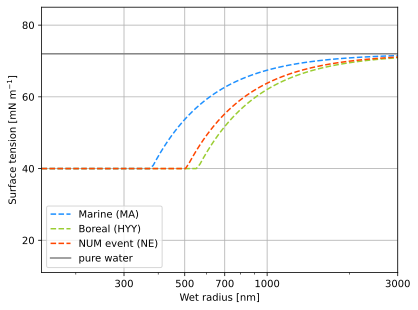

In [6]:
for k, v in cases.items():
    sigma = formulae_surf.surface_tension.sigma(np.nan, v_wet, v_dry, v.modes[0]['f_org'])
    pyplot.plot(r_wet / si.nm, sigma / (si.mN / si.m), label=k, color=v.color, linestyle='--')
pyplot.plot(r_wet / si.nm, np.full_like(r_wet, formulae_bulk.constants.sgm_w / (si.mN / si.m)), label='pure water', color='gray')
pyplot.grid()
pyplot.xscale('log')
pyplot.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
yticks = (20, 40, 60, 80)
pyplot.yticks(yticks, yticks)
pyplot.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pyplot.ylim(11, 85)
pyplot.xlabel('Wet radius [nm]')
pyplot.ylabel('Surface tension [mN m$^{-1}$]')
pyplot.legend()
show_plot("fig_1d.pdf")